In [21]:
from keras import backend as K
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import seaborn as sns
import os
from tensorflow.keras.layers import Input, Dense, Dropout, Conv2D, MaxPooling2D, Flatten, \
    BatchNormalization, Reshape, Conv1D, MaxPooling1D, UpSampling1D
from tensorflow.keras.models import Model, Sequential, load_model
import librosa
import librosa.display
from keras_tuner import HyperModel
from keras_tuner.tuners import Hyperband
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap, TSNE
import gc
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.losses import mean_squared_error

import warnings
from scipy.sparse import (spdiags, SparseEfficiencyWarning, csc_matrix,
    csr_matrix, isspmatrix, dok_matrix, lil_matrix, bsr_matrix)
warnings.simplefilter('ignore',SparseEfficiencyWarning)

In [22]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

C:\Users\Quentin\anaconda3\envs\tensorflow_keras\lib\site-packages\tensorflow\python\client\session.py:1768: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [23]:
def refresh_memory():
    gc.collect()
    df_file = get_df_files()
    df_file.head()

In [46]:
#Constants
PATH_FEATURES_FOLDER = './Features/'
PATH_MELSPEC_313_128_FOLDER = PATH_FEATURES_FOLDER + 'melspec_313_128/'

def get_df_files():
    
    #Get file paths and labels
    path_files = []
    labels = []

    #Walk through melspectrogram folders
    for subdirectory, directory, files in os.walk(PATH_MELSPEC_313_128_FOLDER):

        #Get label using directory folder name
        label = subdirectory.split('/')[-1]

        #Loop through files
        for file in files:
            path_file = subdirectory + '/' + file
            path_files.append(path_file)
            labels.append(label)
    
    #Create list dictionnary for df
    list_dict_file = []
    
    #Feed dictionnary
    for filepath, label in zip(path_files, labels):
        
        #Get filename
        filename = filepath.split('/')[-1]
        
        #Get filename as list of string
        splitted_filename = filename.split('_')
        
        #Append dictionnary to list
        list_dict_file.append({
            'filepath' : filepath,
            'filename' : filename,
            'section' : int(splitted_filename[1]),
            'domain_env' : splitted_filename[2],
            'dir' : splitted_filename[3],
            'sound_type' : splitted_filename[4],
            'id' : splitted_filename[5],
            'suffix' : '_'.join(splitted_filename[6:]).split('.npy')[0],
            'label' : label
        })

    #Get file dataframe
    df_files = pd.DataFrame(list_dict_file)
    
    #Encode label
    label_encoder = LabelEncoder()
    df_files['label_encoded'] = label_encoder.fit_transform(df_files['label'])
    
    return df_files

In [47]:
def get_reduced_cnn_machinery_clf(nb_of_end_layer = 6):
    
    saved_model = Sequential(
        [Input(shape = (128, 313, 1), name = "Input"),
        Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2), strides=2),
        Dropout(rate=0.1),
        Conv2D(filters=64, kernel_size=5, padding='same', activation='relu'),
         Conv2D(filters=32, kernel_size=5, padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2), strides=2),
        Dropout(rate=0.1),
        Conv2D(filters=128, kernel_size=5, padding='same', activation='relu'),
        Conv2D(filters=64, kernel_size=5, padding='same', activation='relu'),
        Dropout(rate=0.2),
        BatchNormalization(),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(128, activation='relu'),
        Dense(7, activation='softmax')]
    )

    #Load the weights
    saved_model.load_weights('Models/machinery_clf_best_model.hdf5')
    
    #Get reduced model
    reduced_model = Sequential()
    for layer in saved_model.layers[:nb_of_end_layer+1]:
        reduced_model.add(layer)
        
    #Return reduced model 
    return reduced_model

In [48]:
class CenterLossLayer(tf.keras.layers.Layer):
    
    def __init__(self, nb_classes, alpha=0.5, **kwargs):
        super().__init__(**kwargs)
        self.alpha = alpha
        self.nb_classes = nb_classes
        
    def get_config(self):
        config = super().get_config()
        config.update({
            "nb_classes": self.nb_classes,
            "alpha": self.alpha,
        })
        return config
        
        
    def build(self, input_shape):
        
        #Delete later, check first 
        print("Build of center loss layer input_shape : " + str(input_shape[0][1]))
        
        self.centers = self.add_weight(name='centers',
                                       shape=(self.nb_classes, input_shape[0][1]),
                                       initializer='uniform',
                                       trainable=False)
        super().build(input_shape)
        
    def call(self, x, mask=None):

        # x[0] is batchsize*nb_features, x[1] is batchsize*nb_classes onehot, self.centers is nb_classes*nb_features
        
        #Calculate new differences between last class centers and new feature samples
        #Va dans un premier temps calculer la différence delta entre les samples et les centres
        #Et dans un second temps sommer pour chaque feature l'ensemble des différences de tout les samples
        delta_centers = K.dot(K.transpose(x[1]), (K.dot(x[1], self.centers) - x[0]))  # nb_classes*nb_features
        
        #Get number of samples for each classes in batch
        center_counts = K.sum(K.transpose(x[1]), axis=1, keepdims=True) + 1  # nb_classes*1
        
        #Get mean of delta centers
        #Ici on va enfin moyenner les features de différence de chaque classe
        delta_centers /= center_counts
        
        #Update new centers
        new_centers = self.centers - self.alpha * delta_centers
        self.add_update((self.centers, new_centers), x)

        #Calculate difference between features samples and their class centers
        self.result = x[0] - K.dot(x[1], self.centers)
        
        #For each sample sum all the differences squared
        self.result = K.sum(self.result ** 2, axis=1, keepdims=True)
        
        #Return result
        return self.result # batchsize*1 (=pour chaque sample une distance avec le centre)
    
    def compute_output_shape(self, input_shape):
        return K.int_shape(self.result)
    


def center_loss(y_true, y_pred):
    
    """Loss function translating loss calculted by CenterLoss layer"""
        
    #Return the sum of all the losses divided by two
    return 0.5 * K.sum(y_pred, axis=0)

In [49]:
def load_model_section_clf_w_centerloss(type_machinery, lambda_centerloss):
    
    #Get lambda as scientifice notation (ex: 1e-5)
    lambda_scientific_notation = "{:.0e}".format(lambda_centerloss)
    
    #Load model
    model = load_model('Models/2022_07_10/section_clf_w_centerloss_' + type_machinery \
                     + '_' + lambda_scientific_notation + '.hdf5', 
                       custom_objects={
                           'CenterLossLayer': CenterLossLayer,
                           'center_loss' : center_loss
                       }
                      )
    
    #Return model
    return model
    

In [50]:
def get_aux_out_model(complete_model):
    return Model(complete_model.inputs,  complete_model.get_layer('aux_out').output)

In [51]:
def get_centroids_centerloss(complete_model):
    
    #Get centerloss_layer
    centerloss_layer = complete_model.get_layer('centerlosslayer')
    
    #Return centroids
    return centerloss_layer.centers

In [52]:
def get_list_embedding_section_soundtype(type_machinery, model_section_clf, directory='train', sound_type='normal',
                                        nb_samples_per_class = 500, nb_classes=3):
    
    #Get type machinery clf
    machinery_model = get_reduced_cnn_machinery_clf()
    
    #Get data from test dataset
    df_file = get_df_files()
    df_file_sampled = df_file[(df_file['label']==type_machinery) & (df_file['dir']==directory) \
        & (df_file['sound_type']==sound_type)].groupby(['section']).apply(lambda group: group.sample(nb_samples_per_class))
    
    #Get input data, section and sound_types
    filepaths = df_file_sampled['filepath'].tolist()
    data = np.asarray(np.asarray([np.load(file).reshape(128, 313, 1) for file in filepaths]))
    sections = df_file_sampled['section']
    sound_types = df_file_sampled['sound_type']
    sections_as_cat_one_hot = tf.keras.utils.to_categorical(sections, num_classes=nb_classes)
    
    #Get embeddings
    embeddings = model_section_clf.predict((machinery_model.predict(data), sections_as_cat_one_hot))
    embeddings = embeddings.reshape(nb_samples_per_class*nb_classes, 128)
    
    return embeddings, sections, sound_types

In [53]:
def get_distance_embeddings_centroids(embeddings, sections, centers, nb_classes=3):
    
    #Get one hot encoded sections 
    sections_as_cat_one_hot = tf.keras.utils.to_categorical(sections, num_classes=nb_classes)
    
    #embeddings: nb_samples * features
    #sections_as_cat_one_hot: nb_samples * nb_classes
    #centers: nb_classe * features
    
    #Calculate difference between centers and embeddings samples: nb_samples * features
    differences = embeddings - K.dot(tf.convert_to_tensor(sections_as_cat_one_hot), centers)
    
    #Calculate distance: nb_samples * 1
    distances = K.sum((differences ** 2)**0.5, axis=1, keepdims=True)
    
    #Return a the distance vector nb_samples * 1
    return distances.numpy()
    

In [54]:
def get_distances_section_specific(all_distances, sections, section_wanted):
    return all_distances[sections == section_wanted]

In [55]:
def get_distance_percentile_threshold_foreach_sections(distances, sections, percentile=95):
    
    #distances: nb_samples * 1
    #sections : nb_samples * 1
    
    #Get distances for each section
    distances_section0 = get_distances_section_specific(distances, sections, 0)
    distances_section1 = get_distances_section_specific(distances, sections, 1)
    distances_section2 = get_distances_section_specific(distances, sections, 2)
    
    #Get threshold for each section
    threshold_section0 = np.percentile(distances_section0, percentile)
    threshold_section1 = np.percentile(distances_section1, percentile)
    threshold_section2 = np.percentile(distances_section2, percentile)
    
    #Return thresholds
    return threshold_section0, threshold_section1, threshold_section2

In [56]:
def pred_anomaly(distances, sections, thresholds):
    
    #Init list of boolean anomaly (True anomoly, False normal)
    is_anomaly = []
    
    #Loop through distances and sections
    idx = 0
    for distance, section in zip(distances, sections):
        
        #Get section specific threshold
        current_threshold = thresholds[section]
        
        #Add boolean determining anomaly
        is_anomaly.append(distance > current_threshold)
        
        idx += 1
        
    #Transform as np array
    is_anomaly = np.asarray(is_anomaly)
    
    return is_anomaly

In [57]:
def get_list_thresholds(type_machinery, reduced_sct_clf_model, centers, percentile_threshold):
    
    #Get embeddings normal from training dataset
    embeddings_normal_train, sections_normal_train, sound_types_normal_train = \
        get_list_embedding_section_soundtype(type_machinery, reduced_sct_clf_model)
    
    #Get distances
    distances_normal_train = get_distance_embeddings_centroids(embeddings_normal_train, sections_normal_train, centers)
    
    #Get thresholds for each sections
    threshold_s0, threshold_s1, threshold_s2 = \
        get_distance_percentile_threshold_foreach_sections(distances_normal_train, sections_normal_train, percentile=percentile_threshold)
    
    #Get list of thresholds
    list_thresholds = [threshold_s0, threshold_s1, threshold_s2]
    
    #Return list
    return list_thresholds
    
    

In [58]:
def get_df_pred(type_machinery, reduced_section_clf_model, centers, list_thresholds, directory, sound_type, 
                nb_samples_per_class=100):

    #Get embeddings, sections and sound_types
    embeddings, sections, sound_types = \
        get_list_embedding_section_soundtype(type_machinery, reduced_section_clf_model, directory=directory, 
                                             sound_type=sound_type, nb_samples_per_class = nb_samples_per_class)
    
    #Get distances
    distances = get_distance_embeddings_centroids(embeddings, sections, centers)
    
    #Get predictions normal test
    preds = pred_anomaly(distances, sections, list_thresholds)
    
    #Get df of normal test
    df = pd.DataFrame({
        'n' : np.arange(0, len(preds)),
        'section' : sections.values.reshape(len(preds)),
        'distance' : distances.reshape(len(preds)),
        'real_class' : sound_types.replace(['normal', 'anomaly'], [False, True]).values,
        'predicted_class' : preds.reshape(len(preds))
    })
    
    return df

In [59]:
def get_df_pred_normal_anomaly_test(type_machinery, lambda_centerloss, percentile_threshold):

    refresh_memory()

    #Get complete section clf
    complete_model = load_model_section_clf_w_centerloss(type_machinery, lambda_centerloss)

    #Get reduced model to get embeddings
    reduced_model = get_aux_out_model(complete_model)

    #Get centroids of each sections
    centers = get_centroids_centerloss(complete_model)

    #Get list of thresholds
    list_thresholds = get_list_thresholds(type_machinery, reduced_model, centers, percentile_threshold)

    #Get df of normal test
    df_normal_test = get_df_pred(type_machinery, reduced_model, centers, list_thresholds, 
                                 directory='test', sound_type='normal', nb_samples_per_class=100)

    #Get df of anomaly test
    df_anomaly_test = get_df_pred(type_machinery, reduced_model, centers, list_thresholds, 
                                 directory='test', sound_type='anomaly', nb_samples_per_class=100)

    #Concat both df
    df = pd.concat([df_normal_test, df_anomaly_test], axis=0)
    
    #return df
    return df



In [60]:
def get_fpr_tpr_roc_curve(df_pred_true):
    fpr, tpr, thresholds = roc_curve(df_pred_true['real_class'], df_pred_true['predicted_class'])
    return fpr, tpr

def get_roc_auc_score(df_pred_true):
    return roc_auc_score(df_pred_true['real_class'], df_pred_true['predicted_class'])

In [61]:
def plot_roc_curve(fpr, tpr, auc, percentile_threshold):
    
    #Plot roc auc score
    plt.plot(fpr, tpr)
    plt.plot([0,1], [0,1], 'r--')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve with percentile_threshold : ' + str(round(percentile_threshold, 2)) + ' auc : ' + str(auc))
    
#     #Print confusion matrix
#     print(pd.crosstab(df['real_class'], df['predicted_class'], rownames=['Classes réelles'],
#                colnames=['Classes prédites']))
    
    

# Valve

Build of center loss layer input_shape : 128


ResourceExhaustedError: OOM when allocating tensor with shape[1500,64,156,32] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:ConcatV2] name: concat

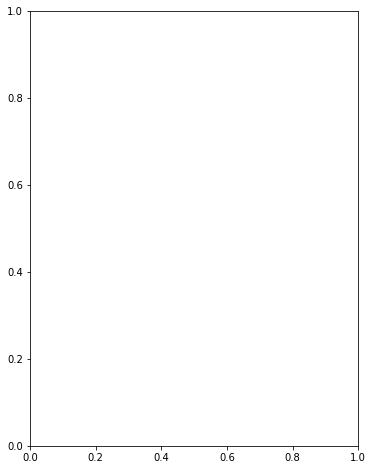

In [62]:
type_machinery = 'valve'
lambda_centerlosses = [0.000001, 0.0000000001]
percentile_thresholds = [90, 95, 99]

for lambda_centerloss in lambda_centerlosses:
    plt.figure(figsize=(20,8))
    for idx, percentile_threshold in enumerate(percentile_thresholds):
        plt.subplot(1,len(percentile_thresholds),idx+1)
        df = get_df_pred_normal_anomaly_test(type_machinery, lambda_centerloss, percentile_threshold)
        fpr, tpr = get_fpr_tpr_roc_curve(df)
        auc = get_roc_auc_score(df)
        plot_roc_curve(fpr, tpr, auc, percentile_threshold)
    
    plt.suptitle(type_machinery + ' : lambda centerloss ' + str(lambda_centerloss))
    plt.show()
        



# bearing

In [ ]:
type_machinery = 'bearing'
lambda_centerlosses = [0.00000001, 0.00000000001]
percentile_thresholds = [90, 95, 99]

for lambda_centerloss in lambda_centerlosses:
    plt.figure(figsize=(20,20))
    for idx, percentile_threshold in enumerate(percentile_thresholds):
        plt.subplot(1,len(percentile_thresholds),idx+1)
        df = get_df_pred_normal_anomaly_test(type_machinery, lambda_centerloss, percentile_threshold)
        fpr, tpr = get_fpr_tpr_roc_curve(df)
        auc = get_roc_auc_score(df)
        plot_roc_curve(fpr, tpr, auc, percentile_threshold)
    
    plt.suptitle(type_machinery + ' : lambda centerloss ' + str(lambda_centerloss))
    plt.show()
        



# fan

In [ ]:
type_machinery = 'fan'
lambda_centerlosses = [0.000001]
percentile_thresholds = [90, 95, 99]

for lambda_centerloss in lambda_centerlosses:
    plt.figure(figsize=(20,20))
    for idx, percentile_threshold in enumerate(percentile_thresholds):
        plt.subplot(1,len(percentile_thresholds),idx+1)
        df = get_df_pred_normal_anomaly_test(type_machinery, lambda_centerloss, percentile_threshold)
        fpr, tpr = get_fpr_tpr_roc_curve(df)
        auc = get_roc_auc_score(df)
        plot_roc_curve(fpr, tpr, auc, percentile_threshold)
    
    plt.suptitle(type_machinery + ' : lambda centerloss ' + str(lambda_centerloss))
    plt.show()
        



# gearbox

In [ ]:

type_machinery = 'gearbox'
lambda_centerlosses = [0.000000001, 0.0000000001]
percentile_thresholds = [90, 95, 99]

for lambda_centerloss in lambda_centerlosses:
    plt.figure(figsize=(20,20))
    for idx, percentile_threshold in enumerate(percentile_thresholds):
        plt.subplot(1,len(percentile_thresholds),idx+1)
        df = get_df_pred_normal_anomaly_test(type_machinery, lambda_centerloss, percentile_threshold)
        fpr, tpr = get_fpr_tpr_roc_curve(df)
        auc = get_roc_auc_score(df)
        plot_roc_curve(fpr, tpr, auc, percentile_threshold)
    
    plt.suptitle(type_machinery + ' : lambda centerloss ' + str(lambda_centerloss))
    plt.show()
        



# slider

In [ ]:
type_machinery = 'slider'
lambda_centerlosses = [0.000000001, 0.0000000001]
percentile_thresholds = [90, 95, 99]

for lambda_centerloss in lambda_centerlosses:
    plt.figure(figsize=(20,20))
    for idx, percentile_threshold in enumerate(percentile_thresholds):
        plt.subplot(1,len(percentile_thresholds),idx+1)
        df = get_df_pred_normal_anomaly_test(type_machinery, lambda_centerloss, percentile_threshold)
        fpr, tpr = get_fpr_tpr_roc_curve(df)
        auc = get_roc_auc_score(df)
        plot_roc_curve(fpr, tpr, auc, percentile_threshold)
    
    plt.suptitle(type_machinery + ' : lambda centerloss ' + str(lambda_centerloss))
    plt.show()
        



# ToyCar

In [ ]:
type_machinery = 'ToyCar'
lambda_centerlosses = [0.000000001]
percentile_thresholds = [90, 95, 99]

for lambda_centerloss in lambda_centerlosses:
    plt.figure(figsize=(20,20))
    for idx, percentile_threshold in enumerate(percentile_thresholds):
        plt.subplot(1,len(percentile_thresholds),idx+1)
        df = get_df_pred_normal_anomaly_test(type_machinery, lambda_centerloss, percentile_threshold)
        fpr, tpr = get_fpr_tpr_roc_curve(df)
        auc = get_roc_auc_score(df)
        plot_roc_curve(fpr, tpr, auc, percentile_threshold)
    
    plt.suptitle(type_machinery + ' : lambda centerloss ' + str(lambda_centerloss))
    plt.show()
        



# ToyTrain

In [ ]:
type_machinery = 'ToyTrain'
lambda_centerlosses = [0.000000001]
percentile_thresholds = [90, 95, 99]

for lambda_centerloss in lambda_centerlosses:
    plt.figure(figsize=(20,20))
    for idx, percentile_threshold in enumerate(percentile_thresholds):
        plt.subplot(1,len(percentile_thresholds),idx+1)
        df = get_df_pred_normal_anomaly_test(type_machinery, lambda_centerloss, percentile_threshold)
        fpr, tpr = get_fpr_tpr_roc_curve(df)
        auc = get_roc_auc_score(df)
        plot_roc_curve(fpr, tpr, auc, percentile_threshold)
    
    plt.suptitle(type_machinery + ' : lambda centerloss ' + str(lambda_centerloss))
    plt.show()
        

